<a href="https://colab.research.google.com/github/wdoppenberg/art-deep-transfer-learning/blob/master/Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
cd /content/drive/My\ Drive/Colab\ Notebooks/cs4240-project


/content/drive/.shortcut-targets-by-id/1qYhyzoN-xaPWkyz7yLQfu4Pnb8uzG43y/cs4240-project


In [0]:
DATASETS_PATH='datasets/Jap/'

In [8]:
pip install -q -r requirements.txt

     |████████████████████████████████| 7.8MB 33.5MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 


In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import io
import random
import time
from numpy import asarray
from numpy import savetxt

import torch
from torchvision import models, transforms
import torch.nn as nn
from torch.optim import SGD

import h5py
import utils
from efficientnet_pytorch import EfficientNet



In [10]:
if torch.cuda.is_available():
        print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
        print('Using CPU')

Using GPU: Tesla T4


In [0]:
CHECKPOINT_PATH = 'models/PyTorch/'
test_path = DATASETS_PATH+'testing.hdf5'

input_size = 224
batch_size = 32

labels = {
    'material':'material_cat',
    'type':'type_cat',
    'creator':'fullname_creator_cat'
}

classes = {
    'material':128,
    'type':534,
    'creator':6620
}

norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)

transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
])

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnormalize = UnNormalize(norm_mean, norm_std)

TensorToImage = transforms.ToPILImage(mode='RGB')

class HDF5Dataset(torch.utils.data.Dataset):
    def __init__(self, path, challenge):
        self.f = h5py.File(path, 'r')

        self.n_images = len(self.f['images'])
        self.challenge = challenge

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (
            transform(
                Image.open(
                    io.BytesIO(self.f['images'][idx])
                ).convert('RGB')
            ),
            int(self.f[self.challenge][idx])
        )
    
    def random(self):
        return self.__getitem__(
            random.randint(0, self.n_images)
        )

    def __len__(self):
        return self.n_images

    def __del__(self):
        self.f.close()

test_dataset_creator = HDF5Dataset(test_path, labels['creator'])
test_loader_creator = torch.utils.data.DataLoader(test_dataset_creator, batch_size=1, shuffle=True)
test_dataset_type = HDF5Dataset(test_path, labels['type'])
test_loader_type = torch.utils.data.DataLoader(test_dataset_type, batch_size=1, shuffle=True)
test_dataset_material = HDF5Dataset(test_path, labels['material'])
test_loader_material = torch.utils.data.DataLoader(test_dataset_material, batch_size=1, shuffle=True)


In [0]:
def get_model(name, pretrained, nc):
    if name == 'VGG19':
        model = models.vgg19(pretrained=pretrained)
        model.classifier[6] = nn.Linear(4096, nc)
        return model

    elif name == 'ResNet50':
        model = models.resnet50(pretrained=pretrained)
        model.fc = nn.Linear(2048, nc)
        return model

    elif name == 'EfficientNet':
        if pretrained:
            model = EfficientNet.from_pretrained('efficientnet-b7')
        else:
            model = EfficientNet.from_name('efficientnet-b7')
        model._fc = nn.Linear(2560, nc)
        return model
    else:
        print(f'Model called {name} not found...')

# **Testing**


In [10]:
savefile_name = 'EffNetFTmaterial'
Challenges = ['material']             # ['creator', 'type', 'material']
MODELS = ['EfficientNet']            # ['VGG19', 'ResNet50', 'EfficientNet']
Training_modes = ['FineTuning']            # ['OffTheShelf', 'FineTuning']
All_test_accuracy = []
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-3
momentum = 0.9
i=0
for challenge in Challenges:
  num_classes = classes[challenge]
  #test_path_full=test_path+labels[challenge]
  #print(test_path_full)
  #print(num_classes)
  for MODEL in MODELS:
    for training_mode in Training_modes:
      if training_mode == 'OffTheShelf':
        pretrained = False
      else:
        pretrained = True
      CHECKPOINT_PATH_full=CHECKPOINT_PATH+challenge+'/'+MODEL+'_'+training_mode+'_Rijks_'+challenge+'.pth'
      #print(CHECKPOINT_PATH_full)
      if ~torch.cuda.is_available():
        checkpoint = torch.load(CHECKPOINT_PATH_full, map_location=torch.device('cpu'))
      else:    
        checkpoint = torch.load(CHECKPOINT_PATH_full)
      model = get_model(MODEL, pretrained, num_classes)                           #model inladen uit training checkpoint
      model.load_state_dict(checkpoint['model_state_dict'])
      optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)    #optimizer inladen uit training checkpoint
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      if torch.cuda.is_available():                                               # cuda op model zetten
        model.cuda()
        loss_function.cuda()
        #print(f'Using GPU: {torch.cuda.get_device_name(0)}')
      #else:
        #print('Using CPU')

      #picking test set
      if challenge == 'creator':
        test_dataset = test_dataset_creator
        test_loader = test_loader_creator
      elif challenge == 'type':
        test_dataset = test_dataset_type
        test_loader = test_loader_type
      else:
        test_dataset = test_dataset_material
        test_loader = test_loader_material  
       


      #evaluating models on test set
      print('Begin testing on '+MODEL+' '+training_mode+' '+challenge)
      score = 0
      model.eval()
      with torch.no_grad():
          for images, labels in test_loader:
              if torch.cuda.is_available():
                  images, labels = images.cuda(), labels.cuda()
              logits = model(images)

              top_p, top_class = logits.topk(1, dim=1)
              correct = top_class.squeeze() == labels
              score += torch.sum(correct.float())

      test_accuracy = score/len(test_dataset)
      test_accuracy = test_accuracy.item() * 100
      All_test_accuracy.append(test_accuracy)
      print('Accuracy of '+MODEL+' '+training_mode+' '+challenge+' is:')
      print(All_test_accuracy[i])
      np.asarray(All_test_accuracy)
      All_test_accuracy = All_test_accuracy
      np.savetxt(savefile_name+'.csv', All_test_accuracy, delimiter=',', fmt='%f')
      i=i+1
      




          

  


Loaded pretrained weights for efficientnet-b7
Begin testing on EfficientNet FineTuning material
Accuracy of EfficientNet FineTuning material is:
94.9036180973053


In [11]:
print(All_test_accuracy)

[94.9036180973053]


# **Visual Tester**

In [0]:
import pandas as pd

metadata = pd.read_csv(DATASETS_PATH+'metadata_rijks_enc.csv')

df_material = metadata[['material', 'material_cat']].copy()
df_material.drop_duplicates(inplace=True)
df_material.columns = ['string', 'label']

df_type = metadata[['type', 'type_cat']].copy()
df_type.drop_duplicates(inplace=True)
df_type.columns = ['string', 'label']

df_creator = metadata[['fullname_creator', 'fullname_creator_cat']].copy()
df_creator.drop_duplicates(inplace=True)
df_creator.columns = ['string', 'label']

dict_labels = dict(material=df_material, type=df_type, creator=df_creator)

In [17]:
# pick model
challenge = 'type'
MODEL = 'VGG19'
training_mode = 'FineTuning'

# load model
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-3
momentum = 0.9
num_classes = classes[challenge]
if training_mode == 'OffTheShelf':
  pretrained = False
else:
  pretrained = True
model = get_model(MODEL, pretrained, num_classes)

# load checkpoint
CHECKPOINT_PATH_full=CHECKPOINT_PATH+challenge+'/'+MODEL+'_'+training_mode+'_Rijks_'+challenge+'.pth'
print(CHECKPOINT_PATH_full)
if ~torch.cuda.is_available():
  checkpoint = torch.load(CHECKPOINT_PATH_full, map_location=torch.device('cpu'))
else:    
  checkpoint = torch.load(CHECKPOINT_PATH_full)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)    #optimizer inladen uit training checkpoint
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
if torch.cuda.is_available():                                               # cuda op model zetten
 model.cuda()
 loss_function.cuda()

# load test set
if challenge == 'creator':
  test_dataset = test_dataset_creator
  test_loader = test_loader_creator
elif challenge == 'type':
  test_dataset = test_dataset_type
  test_loader = test_loader_type
else:
  test_dataset = test_dataset_material
  test_loader = test_loader_material  




Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth



models/PyTorch/type/VGG19_FineTuning_Rijks_type.pth


Ground truth: [387] schilderij
Prediction: [387] schilderij
Correct!


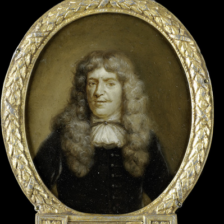

In [0]:
image, label = next(iter(test_loader))
if torch.cuda.is_available():
    image, label = image.cuda(), label.cuda()
model.eval()

logits = model(image)
ground_truth = label.item()
prediction = logits.argmax(dim=1).item() 

df = dict_labels[challenge]
gt_string = df[df['label']==ground_truth]['string'].item()
pred_string = df[df['label']==prediction]['string'].item()
corr = 'Correct!' if prediction==ground_truth else 'Incorrect.'
print(
    f'Ground truth: [{ground_truth}] {gt_string}\n'
    f'Prediction: [{prediction}] {pred_string}\n'+
    corr
)
TensorToImage(unnormalize(image[0].cpu()))

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

141758038

In [15]:
def pytorch_count_params(model):
  "count number trainable parameters in a pytorch model"
  total_params = sum(reduce( lambda a, b: a*b, x.size()) for x in model.parameters())
  return total_params
pytorch_count_params(model)

NameError: ignored